# Final Recap Lab - Solution
---

## Using the KDDCup dataset, find the best SML model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The KDDCup intrusion detection data stream records intrusions simulated in a military network environment. The task is to classify network traffic into **normal** (80.31% of the cases) or some kind of **intrusion** (19.69% of the cases) described by *41 features*, of which *34 numeric* and *7 nominal*. The problem of temporal dependence is particularly evident here. Inspecting the raw stream confirms that there are time periods of intrusions rather than single instances of intrusions.
The *7 nominal* attributes are:
- protocol_type
- service
- flag
- land
- logged_in
- is_host_login
- is_guest_login

**Class:** `class` | 0: normal, 1: intrusion
 
**Samples:** 494021


In [2]:
df = pd.read_csv("../datasets/KDDCup.csv").iloc[:10000,:]
features = df.columns[:-1]
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

## Plot data distribution
---
Encode the protocol_type, service and flag attributes and apply the **PCA**

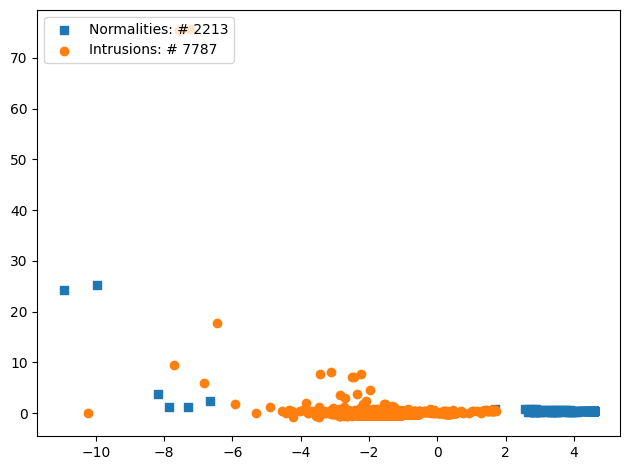

In [3]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

encoder = OrdinalEncoder()
encDf = df.copy()
encDf[["protocol_type","service","flag"]] = encoder.fit_transform(encDf[["protocol_type","service","flag"]])


features = encDf.drop(["class"],axis=1)
label = encDf["class"]

scaled_features = StandardScaler().fit_transform(features)
num_components = 2
pca = PCA(n_components=num_components)
pca_data = pca.fit_transform(scaled_features)
pca_data.shape

pc_df = pd.DataFrame(data = pca_data,columns = ["pc1", "pc2"])
pc_df["class"] = label

normalities = pc_df[pc_df["class"] == 0]
intrusions = pc_df[pc_df["class"] == 1]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x=normalities["pc1"], y=normalities["pc2"], marker="s", label='Normalities: # ' + str(normalities.shape[0]))
ax1.scatter(x=intrusions["pc1"], y=intrusions["pc2"], marker="o", label='Intrusions: # ' + str(intrusions.shape[0]))
plt.legend(loc='upper left');
fig.tight_layout()
plt.show()

## Find the best SML model!
---
### Hint
Since the stream is imbalances, the Accuracy is not a reliable metric. Try using [BalancedAccuracy](https://riverml.xyz/0.21.2/api/metrics/BalancedAccuracy/) and [GeometricMean](https://riverml.xyz/0.21.2/api/metrics/GeometricMean/) instead. To combine them, use [Metrics](https://riverml.xyz/0.21.2/api/metrics/base/Metrics/). Since there can be several drifts, considere using a [Rolling Window](https://riverml.xyz/0.21.2/api/utils/Rolling/) to compute the performance, too.

In [4]:
from river.stream import iter_pandas
from river.metrics.base import Metrics
from river.utils import Rolling
from river.evaluate import iter_progressive_val_score
import matplotlib.pyplot as plt
from river.metrics import Accuracy,BalancedAccuracy,GeometricMean,CohenKappa
from river import compose

In [5]:
# Function to plot the results
def plot_results(steps,plot_title,rolling):
    res = []
    for step in steps:
        if rolling:
            res.append([step['Rolling'].get()[0],step['Rolling'].get()[1],step['Rolling'].get()[2],step['Rolling'].get()[3]])
        else:
            res.append([step['Accuracy'].get(),step['BalancedAccuracy'].get(),step['GeometricMean'].get(),step['CohenKappa'].get()])
    fig = plt.figure()
    plt.plot(res, label=['Accuracy','BalancedAccuracy','GeometricMean','CohenKappa'])
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('Metrics', fontsize=13)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(plot_title)
    plt.show()
    

## Naïve Bayes

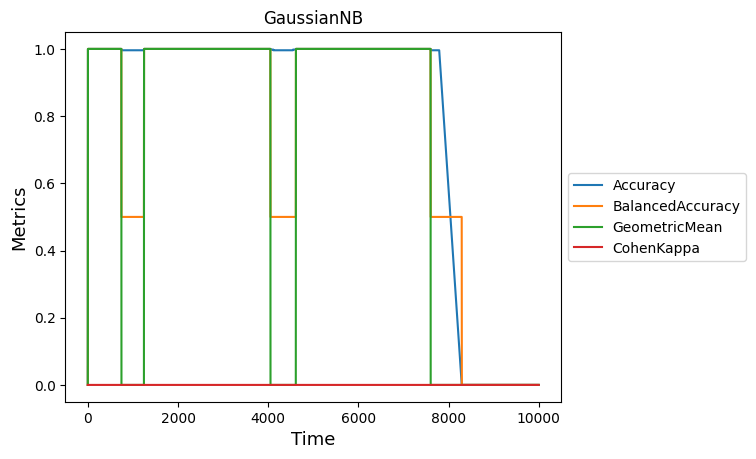

In [6]:
from river.naive_bayes import GaussianNB

model = (
    compose.Discard('protocol_type','service', 'flag') |
    GaussianNB()
)
features = df.columns[:-1]
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=df[features], y=df['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'GaussianNB',rolling=True)

## Hoeffding Adaptive Tree

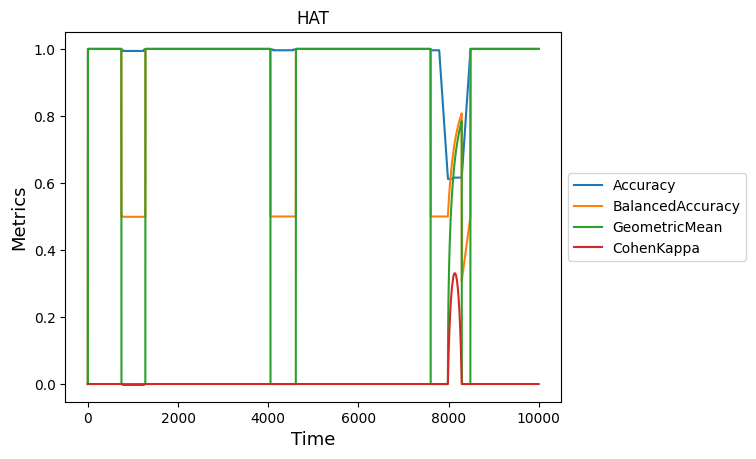

In [7]:
from river.tree import HoeffdingAdaptiveTreeClassifier

model = HoeffdingAdaptiveTreeClassifier(nominal_attributes=['protocol_type','service', 'flag'], seed=42)
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=df[features], y=df['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'HAT',rolling=True)

## Adaptive Random Forest

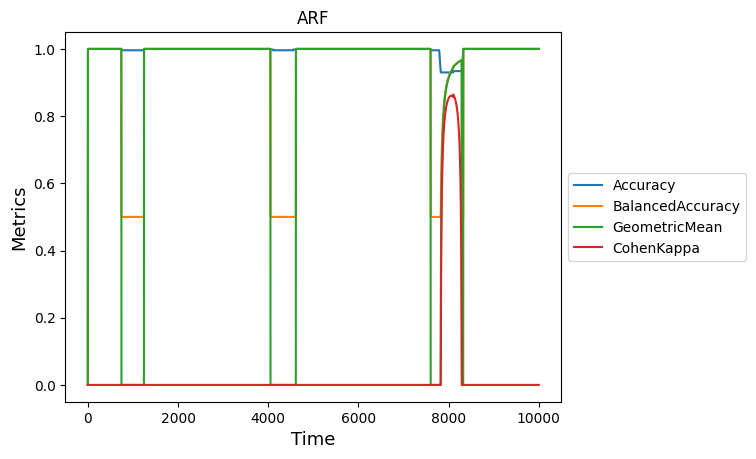

In [8]:
from river.forest import ARFClassifier

model = ARFClassifier(n_models=5,nominal_attributes=['protocol_type','service', 'flag'])
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=df[features], y=df['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'ARF',rolling=True)

## ADWIN Online Bagging

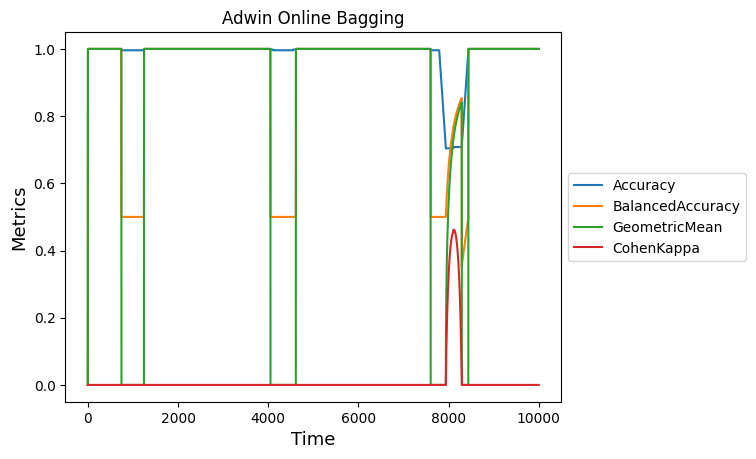

In [9]:
from river.ensemble import ADWINBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = ADWINBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                          n_models=5,
                          seed=42)
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=df[features], y=df['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'Adwin Online Bagging',rolling=True)

## Leveraging Bagging

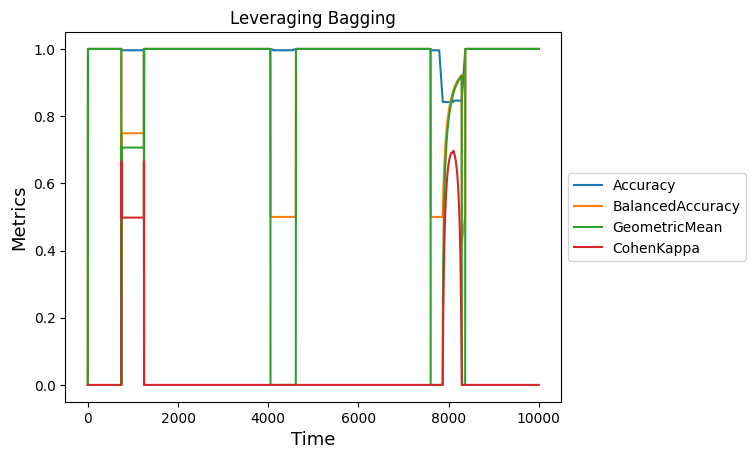

In [10]:
from river.ensemble import LeveragingBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = LeveragingBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                          n_models=5,
                          seed=42)
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=df[features], y=df['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'Leveraging Bagging',rolling=True)

## Streaming Random Patches

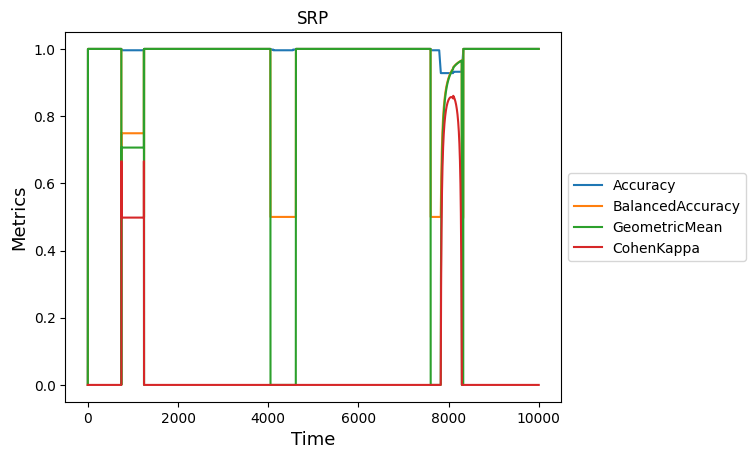

In [11]:
from river.ensemble import SRPClassifier
from river.tree import HoeffdingTreeClassifier
from river.drift import ADWIN

model = SRPClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                      n_models=5,
                      drift_detector=ADWIN(delta=0.001),
                      warning_detector=ADWIN(delta=0.01),
                      seed=42)
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=df[features], y=df['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'SRP',rolling=True)